## Seeing Autonomous Vehicles: Applying Deep Learning to LIDAR Point Cloud data

This code and the associated analysis borrows heavily from the Reference model released by Lyft as part of its kaggle competition, see references at the end of this notebook.

In [1]:
# Edit these to point at where the Level 5 dataset lives on your machine.
d_path='D:/Datasets/Transportation/Lyft/Perception/Modeltrain/'
j_path='D:/Datasets/Transportation/Lyft/Perception/Modeltrain/train_data'

# Our code will generate data, visualization and model checkpoints, they will be persisted to disk in this folder
ARTIFACTS_FOLDER = "D:/Datasets/Transportation/Lyft/Perception/Modeltrain/artifacts"

In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [3]:
import dataprocessing as dp

## 1. Loading and Visualizing the data

In [4]:
level5data = LyftDataset(json_path=j_path, data_path=d_path, verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 14.1 seconds.
Reverse indexing ...
Done reverse indexing in 3.7 seconds.


In [5]:
level5data.list_scenes()

host-a007-lidar0-1230485630199365106-12304856550990... [19-01-02 17:33:50]   25s, Palo Alto, #anns:1559
host-a007-lidar0-1230672860198383106-12306728850991... [19-01-04 21:34:20]   25s, Palo Alto, #anns:2969
host-a007-lidar0-1230936221299185986-12309362461986... [19-01-07 22:43:41]   25s, Palo Alto, #anns:683
host-a007-lidar0-1231093036199514746-12310930610996... [19-01-09 18:17:16]   25s, Palo Alto, #anns:3117
host-a009-lidar0-1231200854198312986-12312008790984... [19-01-11 00:14:14]   25s, Palo Alto, #anns:681
host-a005-lidar0-1231201437298603426-12312014621988... [19-01-11 00:23:57]   25s, Palo Alto, #anns:3064
host-a011-lidar0-1232401360198078026-12324013850983... [19-01-24 21:42:40]   25s, Palo Alto, #anns:3842
host-a011-lidar0-1232412236198491106-12324122610982... [19-01-25 00:43:56]   25s, Palo Alto, #anns:372
host-a007-lidar0-1232470052198454586-12324700770988... [19-01-25 16:47:32]   25s, Palo Alto, #anns:1614
host-a011-lidar0-1232485958298280666-12324859832000... [19-01-25 21

We create a Pandas DataFrame with a row for each of the scenes

In [6]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in
        level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

### 1.1 Creating a training and testing split

We create a Pandas DataFrame with a row for each of the scenes

In [7]:
len(records)

180

In [8]:
df.head(n=5)

,host,scene_name,date,scene_token,first_sample_token
0,host-a007,host-a007-lidar0-1230485630199365106-123048565...,2019-01-02 17:33:50.301987,473093b48a7cb78d05e36245fd2dbd12d66ded7dab1ecb...,c7f7de87ec90c8993d4e7d5463208d2aa9f5ecde671960...
1,host-a007,host-a007-lidar0-1230672860198383106-123067288...,2019-01-04 21:34:20.301189,c62b89d6ae60528c00b8a520bfa16799147f5c2dccbe1e...,07889e50d51717e829cbcb4800e6cb2ce08bdabe92440c...
2,host-a007,host-a007-lidar0-1230936221299185986-123093624...,2019-01-07 22:43:41.402021,694dc7b4629151745d3e1b228b1d6653b0fc1ded12aa8d...,83ce1da2c4b37ca88a102928f01512acf8f55ac7207d04...
3,host-a007,host-a007-lidar0-1231093036199514746-123109306...,2019-01-09 18:17:16.302257,8ed3a2f8cf6e01e0d2c0df7db77839f468ed2aa48b6511...,dddda3940f002b0fa6c495a5ad6d5c4a4c8253aa5ed189...
4,host-a009,host-a009-lidar0-1231200854198312986-123120087...,2019-01-11 00:14:14.301261,a05a48966fbc46666be116a79222374c6c79e6fa930c2f...,8990abea0a146b047a04bc6ed303b16cb1c62cca49bf58...


In [9]:
#add additional date time attributes for 
df['month']=df.date.dt.month
df['hour']=df.date.dt.hour
df['weekday']=df.date.dt.dayofweek

In [10]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
host-a101    20
host-a102    12
Name: scene_token, dtype: int64


### 1.2 Train/Validation split
Let's split the data by car to get a validation set. Here we create the split by host. We greatly reduce the training sample to allow for reasonable training times on a non-GPU, windows laptop. Note that a number of parallelization commands are removed or need to include additional steps to be parallelized in windows + Jupyter notebooks. The first of these is to move a number of functions into a separate python file, and then to introduce if name==main command into the cells.  

In [11]:
validation_hosts = ["host-a009"]
#exclude large hosts for now 
excluded_hosts=["host-a004","host-a007","host-a008","host-a011","host-a015","host-a101","host-a102"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
ei=df[df["host"].isin(excluded_hosts)].index

In [12]:
train_df = df[~(df.index.isin(vi)|df.index.isin(ei))]

In [13]:
len(train_df)

9

In [14]:
train_df.head(n=5)

,host,scene_name,date,scene_token,first_sample_token,month,hour,weekday
5,host-a005,host-a005-lidar0-1231201437298603426-123120146...,2019-01-11 00:23:57.401682,41bdc6cc36d768bb74315128a329e7c6554bd2a6ad6bfc...,cea0bba4b425537cca52b17bf81569a20da1ca6d359f33...,1,0,4
113,host-a012,host-a012-lidar0-1235937130198577346-123593715...,2019-03-06 19:52:10.301498,e8f8379c823fd0505b63f2612505e1d3de1018ecc3328f...,8e1f13379721c1ab1d073607534ce7c195143cb8911715...,3,19,2
126,host-a006,host-a006-lidar0-1236037883198113706-123603790...,2019-03-07 23:51:23.300888,0a6839d6ee6804113bb5591ed99cc70ad883d0cff396e3...,3b30673b9d944ec6058ef5a8debb4c0a6fe075bca7076e...,3,23,3
128,host-a006,host-a006-lidar0-1236038131197892706-123603815...,2019-03-07 23:55:31.300641,44c104f773ac54269ecc3a392ef2c1b708692e81038047...,ed2aa36532e965742736b2c2c698f53bb377d6bff97a0a...,3,23,3
138,host-a017,host-a017-lidar0-1236118873198607026-123611889...,2019-03-08 22:21:13.301300,18c6c670114eebd813ef240b05b988646bbccbbc5254df...,db383de799af143413607152f982bcb685ffdf184452b3...,3,22,4


In [15]:
#all the classes in Lyft & Nuscences datasets
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

### 1.3 Visualize the data

In [16]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

In [ ]:
level5data.get("sample", sample_token)['data']

In [ ]:
#sample = level5data.get("sample", level5data.scene[0]['first_sample_token'])
#sample_lidar_token = sample["data"]["LIDAR_TOP"]
level5data.render_sample_data(sample_lidar_token, axes_limit=40)
#visualize_lidar_of_sample(sample_lidar_token)

In [ ]:
cam_front_token=level5data.get("sample", sample_token)['data']['CAM_FRONT']

In [ ]:
level5data.render_sample_data(cam_front_token, axes_limit=40)

In [ ]:
#shows a 3D visualization of the point-cloud data
#level5data.render_sample_3d_interactive(sample_id=sample_token,render_sample=False)

## B. Creating input and targets

Let's load the first sample in the train set. We can use that to test the functions we'll define next that transform the data to the format we want to input into the model we are training.

In [ ]:
ego_pose

In [ ]:
lidar_data

In [17]:
# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False)

In [ ]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

# A sanity check, the points should be centered around 0 in sensor space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from Sensor along axis")
plt.ylabel("Amount of points")
plt.show()

In [ ]:
# The lidar pointcloud is defined in the sensor's reference frame.
# We want it in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor)
# A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [ ]:
len(lidar_pointcloud.points[0])

In [20]:
map_mask = level5data.map[0]["mask"]

In [18]:
def get_semantic_map_around_ego(map_mask, ego_pose, voxel_size, output_shape):

    def crop_image(image: np.array,
                           x_px: int,
                           y_px: int,
                           axes_limit_px: int) -> np.array:
                x_min = int(x_px - axes_limit_px)
                x_max = int(x_px + axes_limit_px)
                y_min = int(y_px - axes_limit_px)
                y_max = int(y_px + axes_limit_px)

                cropped_image = image[y_min:y_max, x_min:x_max]

                return cropped_image

    pixel_coords = map_mask.to_pixel_coords(ego_pose['translation'][0], ego_pose['translation'][1])
    extent = voxel_size*output_shape[0]*0.5
    scaled_limit_px = int(extent * (1.0 / (map_mask.resolution)))
    mask_raster = map_mask.mask()
    #int(scaled_limit_px * np.sqrt(2))
    cropped = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * np.sqrt(2)))
    #cropped = crop_image(mask_raster, ego_pose['translation'][0], ego_pose['translation'][1], int(scaled_limit_px * np.sqrt(2)))

    
    ypr_rad = Quaternion(ego_pose['rotation']).yaw_pitch_roll
    yaw_deg = -np.degrees(ypr_rad[0])

    rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))
    ego_centric_map = crop_image(rotated_cropped, rotated_cropped.shape[1] / 2, rotated_cropped.shape[0] / 2,
                                 scaled_limit_px)[::-1]
    
    ego_centric_map = cv2.resize(ego_centric_map, output_shape[:2], cv2.INTER_NEAREST)
    return ego_centric_map.astype(np.float32)/255

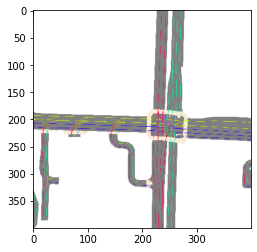

In [21]:
ego_centric_map = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.5, output_shape=(400,400)) 
plt.imshow(ego_centric_map)
plt.show()

As input for our network we voxelize the LIDAR points. That means that we go from a list of coordinates of points, to a X by Y by Z space.

In [54]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))

    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

In [ ]:
np.array((5,5,2))

In [ ]:
(1/np.array((0.5,0.5,0.5)))

In [ ]:
# Let's try it with some example values
tm = create_transformation_matrix_to_voxel_space(shape=(100,100,4), voxel_size=(0.5,0.5,0.5), offset=(0,0,0.5))
p = transform_points(np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype=np.float32), tm)
print("tm",tm)
print("pmatrix",p)
np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype=np.float32)

In [55]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

In [ ]:
voxel_size = (0.2,0.2,2)
z_offset = -2.0
bev_shape = (336, 336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)

# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = normalize_voxel_intensities(bev)

In [ ]:
plt.figure(figsize=(8,8))
#plt.imshow(np.hstack((bev, ego_centric_map)))
plt.imshow((1-bev)*.9)
plt.show()

Above is an example of what the input for our network will look like. It's a top-down projection of the world around the car (the car faces to the right in the image). The height of the lidar points are separated into three bins, which visualized like this these are the RGB channels of the image.

In [ ]:
boxes = level5data.get_boxes(sample_lidar_token)

target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

In [ ]:
move_boxes_to_car_space(boxes, ego_pose)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow((1-(target_im > 0)).astype(np.float32), cmap='Pastel1')
plt.show()

These are the annotations in the same top-down frame, Below we plot the same scene using the NuScenes SDK. Don't worry about it being flipped.

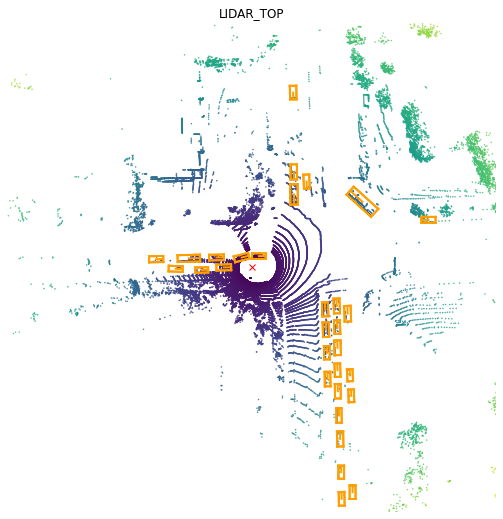

In [26]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
visualize_lidar_of_sample(sample_token)

In [ ]:
sample_token

Now we will run this on all samples in the train and validation set, and write the input and target images to their respective folders.

In [ ]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [ ]:
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

In [ ]:
if __name__== '__main__':
    #to run the code in parallel we use the if name = main format and move all the functions to the 
    #data processing python file
    #"bev" stands for birds eye view
    train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
    validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")
    # Some hyperparameters we'll need to define for the system
    voxel_size = (0.4, 0.4, 1.5)
    z_offset = -2.0
    bev_shape = (336, 336, 3)
    # We scale down each box so they are more separated when projected into our coarse voxel space.
    box_scale = 0.8
    NUM_WORKERS = os.cpu_count()
    for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
        print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
        first_samples = df.first_sample_token.values

        os.makedirs(data_folder, exist_ok=True)
    
        process_func = partial(dp.prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale,
                               level5data=level5data)

        pool = Pool(NUM_WORKERS)
        for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
            pass
        pool.close() 

In [22]:
if __name__== '__main__':
    #to run the code in parallel we use the if name = main format and move all the functions to the 
    #data processing python file
    #"bev" stands for birds eye view
    train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data_alt")
    validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data_alt")
    # Some hyperparameters we'll need to define for the system
    base=0.5
    voxel_size = (0.4*base, 0.4*base, 2)
    z_offset = -2.0
    bev_shape = (336, 336, 3)
    # We scale down each box so they are more separated when projected into our coarse voxel space.
    box_scale = 0.8
    NUM_WORKERS = os.cpu_count()
    for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
        print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
        first_samples = df.first_sample_token.values

        os.makedirs(data_folder, exist_ok=True)
    
        process_func = partial(dp.prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale,
                               level5data=level5data)

        pool = Pool(NUM_WORKERS)
        for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
            pass
        pool.close() 

Preparing data into D:/Datasets/Transportation/Lyft/Perception/Modeltrain/artifacts\bev_train_data_alt using 4 workers


C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Preparing data into D:/Datasets/Transportation/Lyft/Perception/Modeltrain/artifacts\./bev_validation_data_alt using 4 workers


## 2. Training a network to segment objects

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [ ]:
#fcn_resnet50

In [24]:
#original code
class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

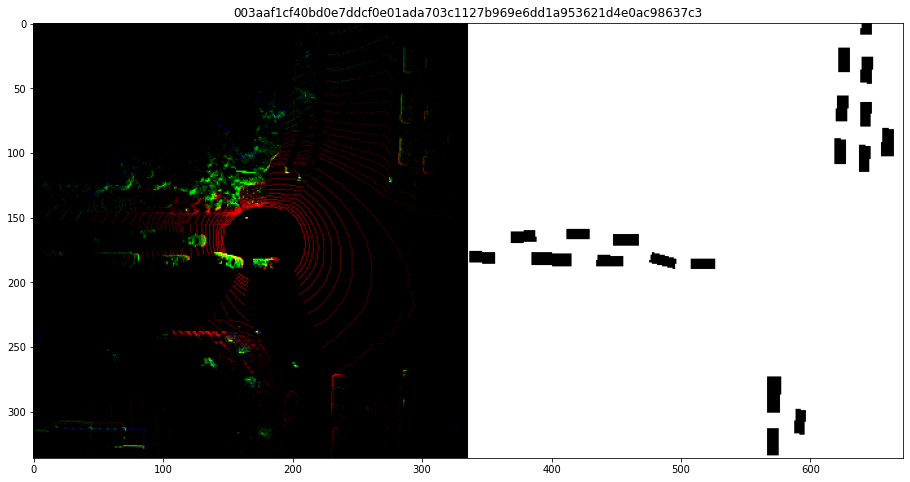

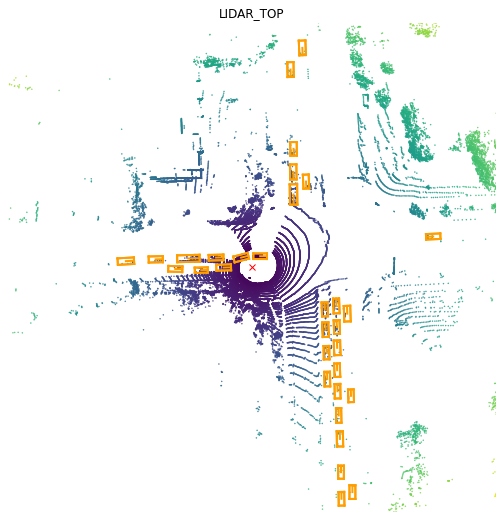

In [27]:
input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))
#map_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_map.png")))

#train_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
train_dataset = BEVImageDataset(input_filepaths[0:500], target_filepaths[0:500])


im, target, sample_token = train_dataset[1]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

target_as_rgb =1-np.repeat(target[...,None], 3, 2)
# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
#plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], im.transpose(1,2,0)[...,3:], target_as_rgb)))
plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))

sample_token=sample_token.split("\\")[-1]
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

In [29]:
2**6

64

### 2.1 Training different network architectures

#### Unet Architecture

In [30]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

We train a U-net fully convolutional neural network.  
We create a U-net that is less deep and with only half the amount of filters compared to the original U-net paper implementation.

In [31]:
def get_unet_model(in_channels=3, num_output_classes=2):
    model = UNet(in_channels=3, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    #model = nn.DataParallel(model)
    return model

In [32]:
def visualize_predictions(input_image, prediction, target, n_images=1, apply_softmax=True):
    """
    Takes as input 3 PyTorch tensors, plots the input image, predictions and targets.
    """
    # Only select the first n images
    prediction = prediction[:n_images]
    target = target[:n_images]
    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    if apply_softmax:
        prediction = scipy.special.softmax(prediction, axis=1)
    class_one_preds = np.hstack(1-prediction[:,0])

    target = np.hstack(target.detach().cpu().numpy())

    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0
    class_rgb[...,1] = target

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3: # Without semantic map input
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:] #With semantic map input
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [33]:
# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

In [34]:
batch_size = 5
epochs = 5

model = get_unet_model(num_output_classes=len(classes)+1)
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
#dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

In [35]:
model

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256,

Epoch 1


C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


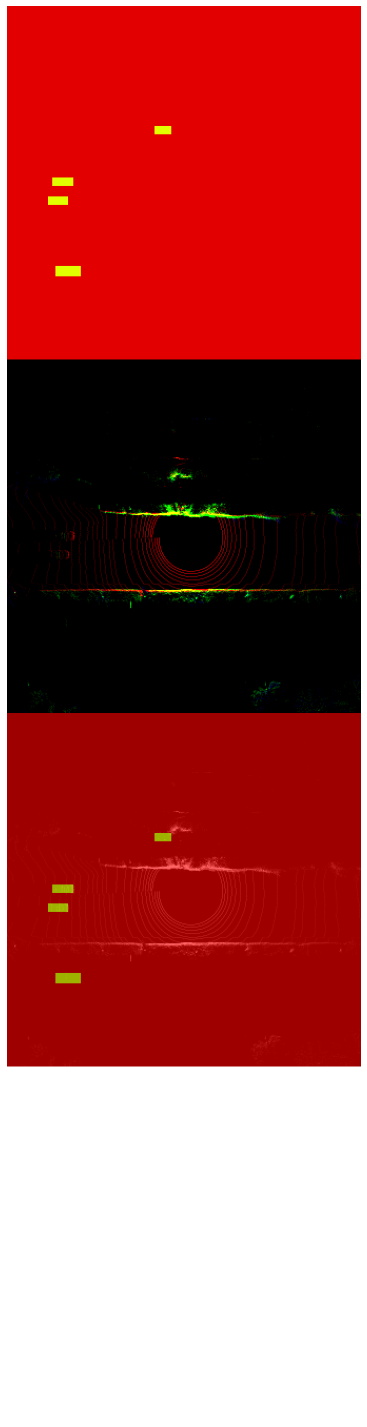


Loss: 0.5574898
Epoch 2


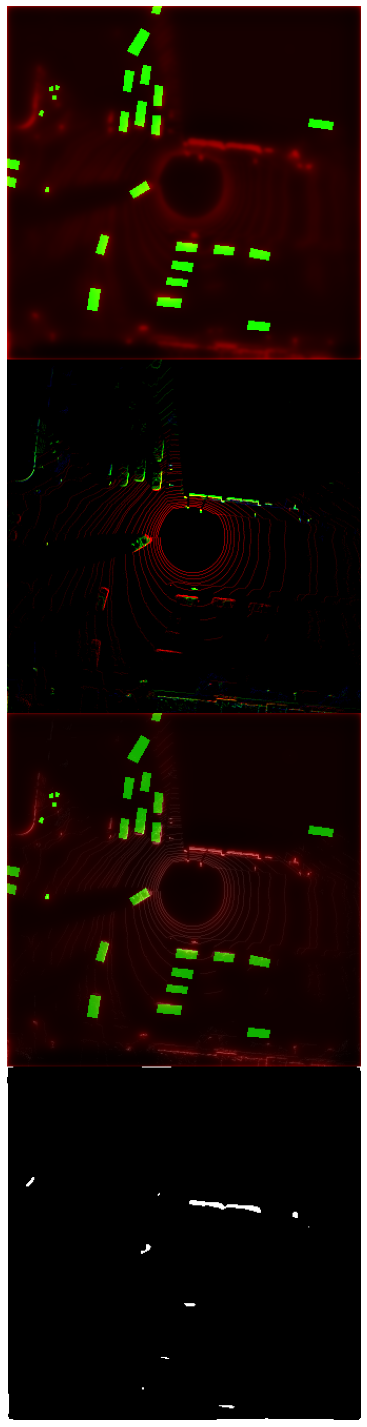


Loss: 0.304696
Epoch 3


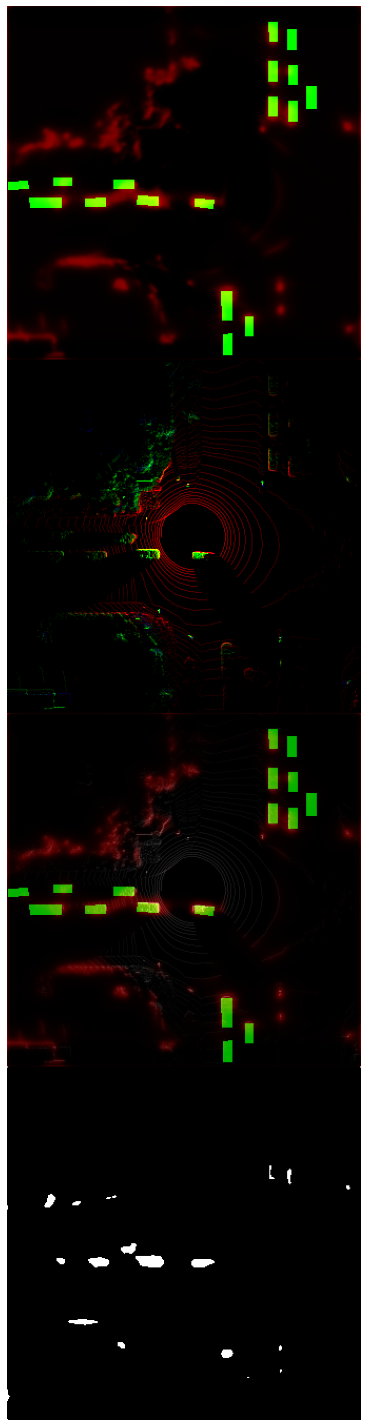


Loss: 0.24963674
Epoch 4


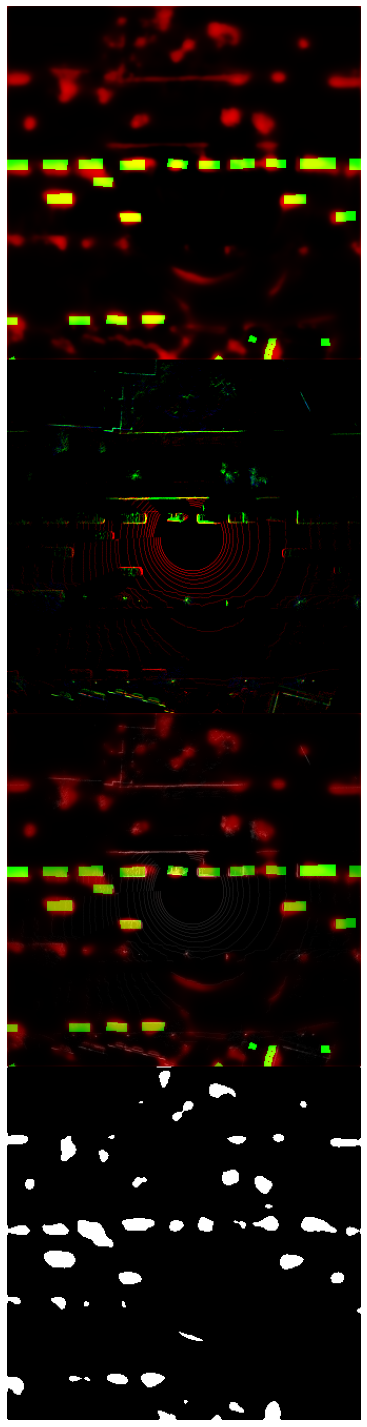


Loss: 0.21927816
Epoch 5


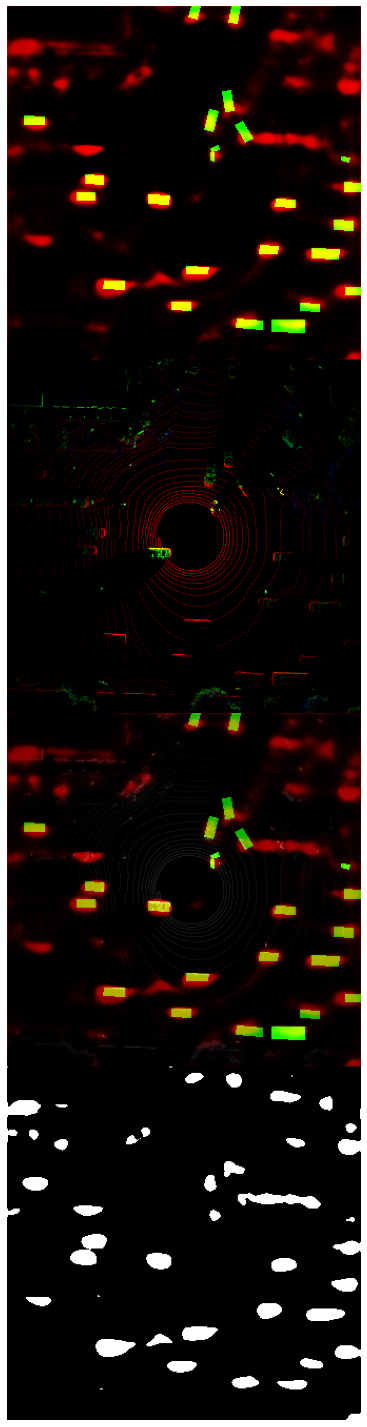


Loss: 0.16750354


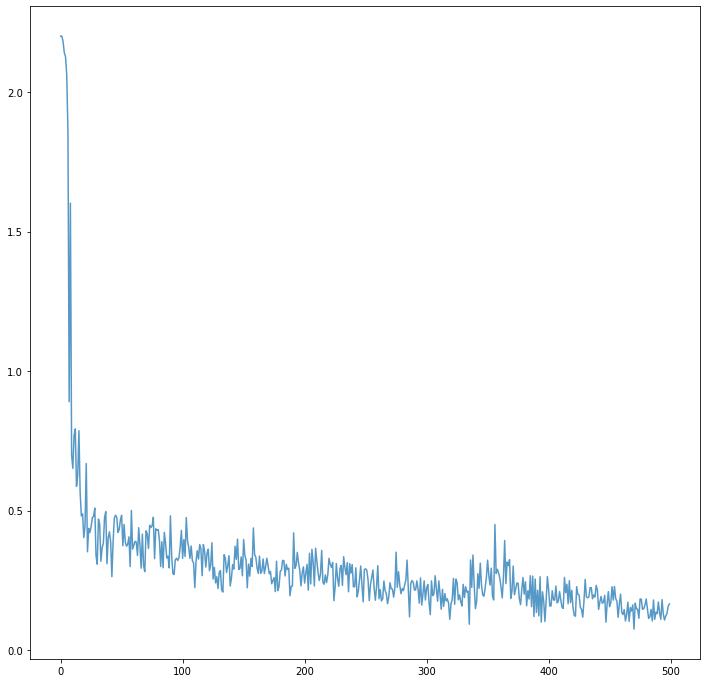

In [36]:
all_losses = []

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    
    epoch_losses = []
    progress_bar = tqdm_notebook(dataloader)
    
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

        if ii == 0:
            visualize_predictions(X, prediction, target)
    
    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)
    
    checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch)
    checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_filepath)
    
plt.figure(figsize=(12,12))
plt.plot(all_losses, alpha=0.75)
plt.show()

#### You can interpret the above visualizations as follows:  
There are four different visualizations stacked on top of eachother:
1. The top images have two color channels: red for predictions, green for targets, with red+green=yellow. In other words:  
**Black**: True Negative  
**Green**: False Negative  
**Yellow**: True Positive  
**Red**: False Positive           
2. The input image                 
3. The predictions thresholded at 0.5 probability.

#### FCN Segmentation Architecture

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

In [ ]:
fcn50

In [ ]:
fcn50=fcn_resnet50(pretrained=False,num_classes=len(classes)+1)

In [ ]:
#fcn_resnet_model = torch.hub.load('fcn_resnet101', pretrained=False)

## D. Inference and postprocessing

In [37]:
input_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_target.png")))
#map_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_map.png")))

batch_size=5
#validation_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
validation_dataset = BEVImageDataset(input_filepaths[0:500], target_filepaths[0:500])
#validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_unet_model(num_output_classes=1+len(classes))
model = model.to(device)

epoch_to_load=5
checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_filepath))

<All keys matched successfully>

In [38]:
len(validation_dataset)

500

C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


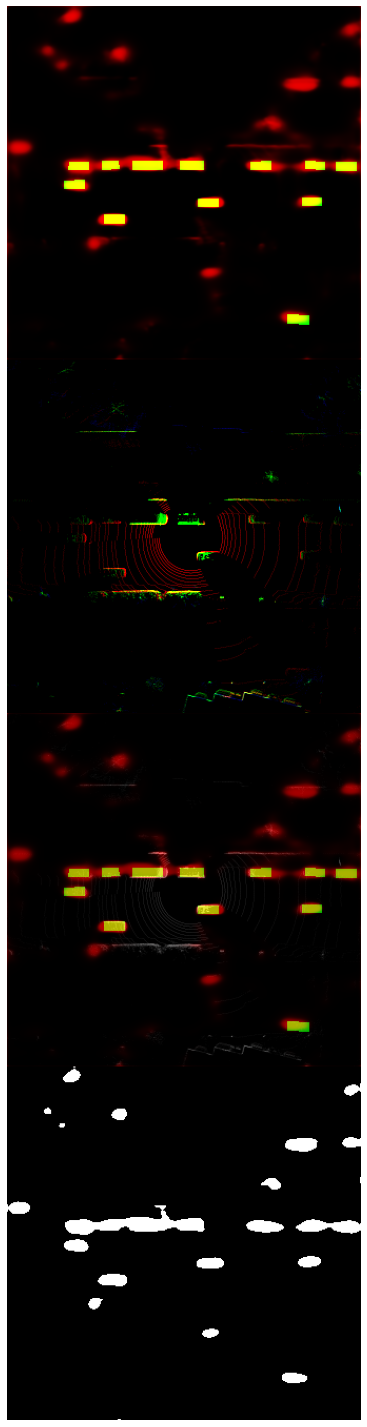


Mean loss: 0.16995122


In [39]:
target_filepaths=target_filepaths[0:500]
progress_bar = tqdm_notebook(validation_dataloader)

targets = np.zeros((len(target_filepaths), 336, 336), dtype=np.uint8)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
predictions = np.zeros((len(target_filepaths), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

with torch.no_grad():
    model.eval()
    for ii, (X, target, batch_sample_tokens) in enumerate(progress_bar):

        offset = ii*batch_size
        targets[offset:offset+batch_size] = target.numpy()
        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)
        all_losses.append(loss.detach().cpu().numpy())
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions[offset:offset+batch_size] = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Visualize the first prediction
        if ii == 0:
            visualize_predictions(X, prediction, target, apply_softmax=False)
            
print("Mean loss:", np.mean(all_losses))

In [40]:
# Get probabilities for non-background
predictions_non_class0 = 255 - predictions[:,0]

In [41]:
predictions[:,0].shape

(500, 336, 336)

In [77]:
255//1.5

170.0

C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


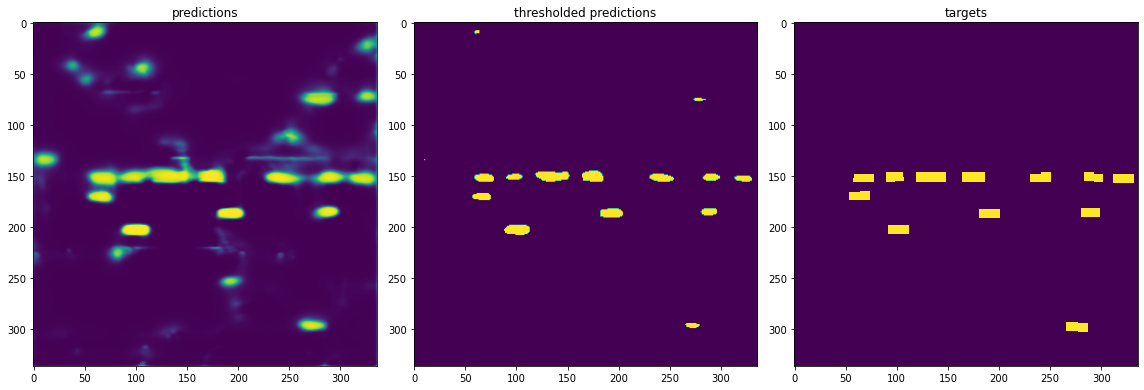

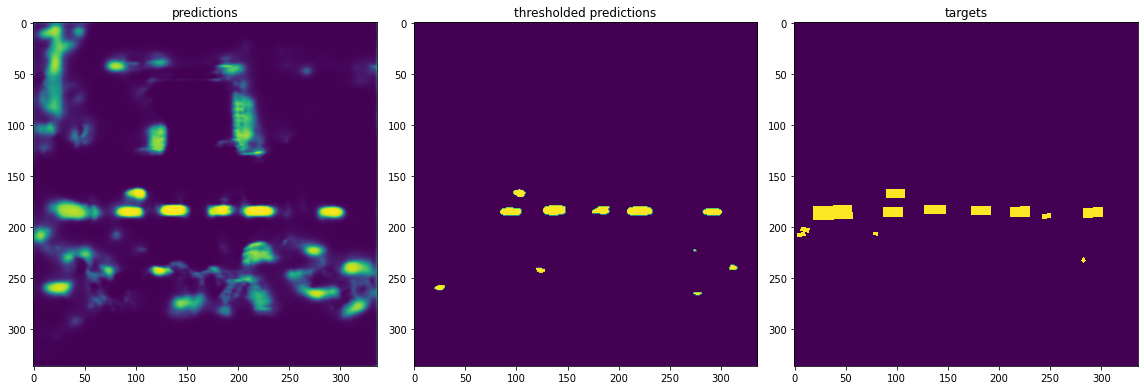

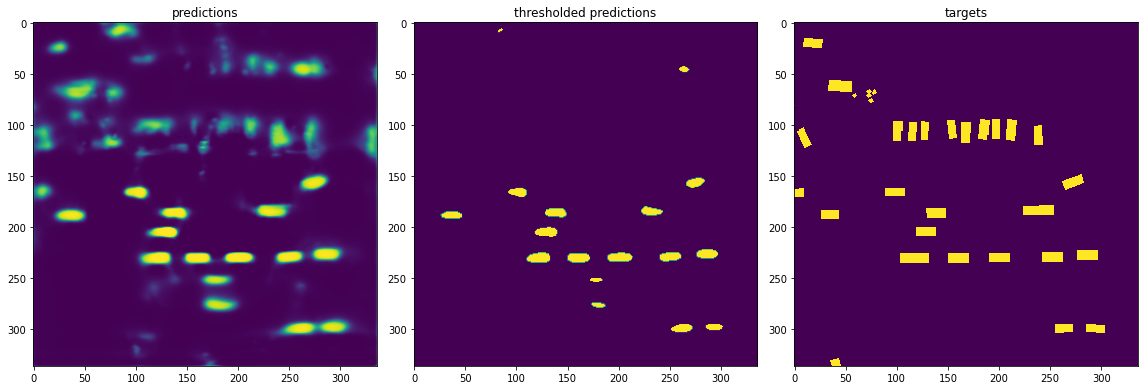

In [70]:
# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 255//1.1

for i in range(3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes[0].imshow(predictions_non_class0[i])
    axes[0].set_title("predictions")
    axes[1].imshow(predictions_non_class0[i] > background_threshold)
    axes[1].set_title("thresholded predictions")
    axes[2].imshow((targets[i] > 0).astype(np.uint8), interpolation="nearest")
    axes[2].set_title("targets")
    fig.tight_layout()
    fig.show()

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1336.75it/s]
C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 864x864 with 0 Axes>

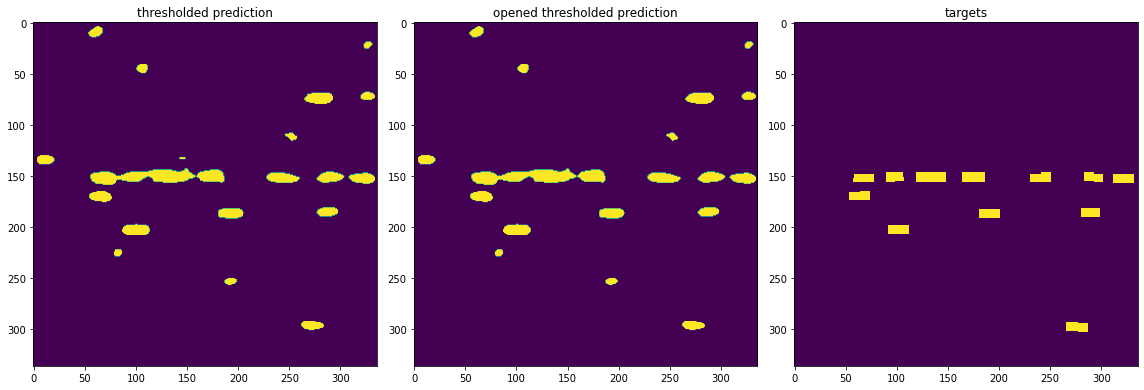

In [45]:
# We perform an opening morphological operation to filter tiny detections
# Note that this may be problematic for classes that are inherently small (e.g. pedestrians)..
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

for i, p in enumerate(tqdm(predictions_non_class0)):
    thresholded_p = (p > background_threshold).astype(np.uint8)
    predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(12,12))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
axes[0].imshow(predictions_non_class0[0] > 255//1.5)
axes[0].set_title("thresholded prediction")
axes[1].imshow(predictions_opened[0])
axes[1].set_title("opened thresholded prediction")
axes[2].imshow((targets[0] > 0).astype(np.uint8), interpolation="nearest")
axes[2].set_title("targets")
fig.tight_layout()
fig.show()

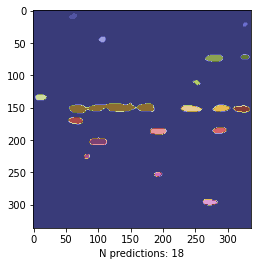

In [46]:
# Sanity check: let's count the amount of connected components in an image
labels, n = scipy.ndimage.label(predictions_opened[0])
plt.imshow(labels, cmap="tab20b")
plt.xlabel("N predictions: {}".format(n))
plt.show()

The above image looks pretty well separated, although some boxes seem to be wrongly merged together. Let's continue.


For each scene we fit boxes to the segmentations. For each box and each class we write it's probability in the center pixel.


In [47]:
len(predictions)

500

C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Total amount of boxes: 27454


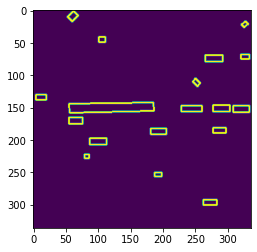

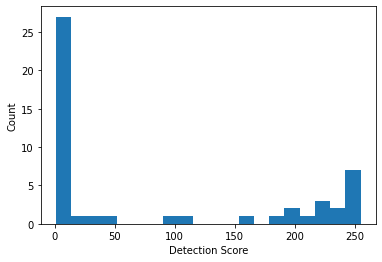

In [48]:
detection_boxes = []
detection_scores = []
detection_classes = []

for i in tqdm_notebook(range(len(predictions))):
    prediction_opened = predictions_opened[i]
    probability_non_class0 = predictions_non_class0[i]
    class_probability = predictions[i]

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    #_, contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
        
    
    detection_boxes.append(np.array(sample_boxes))
    detection_scores.append(sample_detection_scores)
    detection_classes.append(sample_detection_classes)
    
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

In [49]:
detection_classes[0][0:10]

['car',
 'other_vehicle',
 'car',
 'other_vehicle',
 'car',
 'bus',
 'truck',
 'other_vehicle',
 'car',
 'car']

In [ ]:
len(detection_scores)

Now let's load the groundtruth. The nuScenes SDK format provides the EvalBox and EvalBoxes class that allows us to represent the targets and predictions in a structured way, and visualize them using them using built-in functions. See the [nuScenes Detection Task](https://github.com/lyft/nuscenes-devkit/tree/master/python-sdk/nuscenes/eval/detection) page in the SDK.

In [50]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision

def load_groundtruth_boxes(nuscenes, sample_tokens):
    gt_box3ds = []

    # Load annotations and filter predictions and annotations.
    for sample_token in tqdm_notebook(sample_tokens):

        sample = nuscenes.get('sample', sample_token)
        sample_annotation_tokens = sample['anns']

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        ego_translation = np.array(ego_pose['translation'])
        
        for sample_annotation_token in sample_annotation_tokens:
            sample_annotation = nuscenes.get('sample_annotation', sample_annotation_token)
            sample_annotation_translation = sample_annotation['translation']
            
            class_name = sample_annotation['category_name']
            
            box3d = Box3D(
                sample_token=sample_token,
                translation=sample_annotation_translation,
                size=sample_annotation['size'],
                rotation=sample_annotation['rotation'],
                name=class_name
            )
            gt_box3ds.append(box3d)
            
    return gt_box3ds

In [51]:
sample_tokens=[sample_tokens[i].split("\\")[-1].replace("bev_validation_data","") for i in range(len(sample_tokens))]

In [52]:
gt_box3ds = load_groundtruth_boxes(level5data, sample_tokens)

C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Next we take our predicted boxes, transform them back into world space and make them 3D.

In [56]:
pred_box3ds = []
box_scale=0.8


for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)


    # We don't know the height of our boxes, let's assume every object is the same height.
    box_height = 1.75

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)

C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


C:\Users\talha\Anaconda2\envs\lyft\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: `from_dcm` is deprecated!
from_dcm is renamed to from_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0


In [57]:
import json

gt = [b.serialize() for b in gt_box3ds]

pred = [b.serialize() for b in pred_box3ds]

In [58]:
with open(os.path.join(ARTIFACTS_FOLDER, "gt2_alt.json"), "w") as f:
    json.dump(gt, f)

with open(os.path.join(ARTIFACTS_FOLDER, "pred2_alt.json"), "w") as f:
    json.dump(pred, f)

In [66]:
!python ../Lyft-Perception/nuscenes-devkit/lyft_dataset_sdk/eval/detection/mAP_evaluation.py --pred_file pred2_alt.json --gt_file gt2_alt.json --iou_threshold 0.75

Class_names =  ['bicycle', 'bus', 'car', 'motorcycle', 'other_vehicle', 'pedestrian', 'truck']
Average per class mean average precision =  4.190024800855528e-07
('bicycle', 0.0)
('bus', 0.0)
('car', 2.9330173605988697e-06)
('motorcycle', 0.0)
('other_vehicle', 0.0)
('pedestrian', 0.0)
('truck', 0.0)


### References 
1) Level 5 Kaggle Reference Model Lyft Level 5 Kaggle competition by Guido Zuidhof - [gzuidhof@lyft.com]        
2) https://github.com/pochih/FCN-pytorch/blob/master/python/train.py         
3) Lyft Level 5 and Nuscenes Tutorial    